In [1]:
import numpy as np
import tenpy
import time
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.algorithms import dmrg

In [2]:
def example_DMRG_tf_ising_infinite_S_xi_scaling(g):
    model_params = dict(L=10, J=1., g=g, bc_MPS='infinite', conserve='best', verbose=1)
    M = TFIChain(model_params)
    product_state = ["up"] * M.lat.N_sites
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'start_env': 10,
        'mixer': False,
        #  'mixer_params': {'amplitude': 1.e-3, 'decay': 5., 'disable_after': 50},
        'trunc_params': {
            'chi_max': 5,
            'svd_min': 1.e-10
        },
        'max_E_err': 1.e-9,
        'max_S_err': 1.e-6,
        'update_env': 0,
        'verbose': 1
    }

    chi_list = np.arange(7, 31, 2)
    s_list = []
    xi_list = []
    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)

    for chi in chi_list:

        t0 = time.time()
        eng.reset_stats(
        )  # necessary if you for example have a fixed numer of sweeps, if you don't set this you option your simulation stops after initial number of sweeps!
        eng.trunc_params['chi_max'] = chi
        ##   DMRG Calculation    ##
        print("Start IDMRG CALCULATION")
        eng.run()
        eng.engine_params['mixer'] = None
        psi.canonical_form()

        ##   Calculating bond entropy and correlation length  ##
        s_list.append(np.mean(psi.entanglement_entropy()))
        xi_list.append(psi.correlation_length())

        print(chi,
              time.time() - t0,
              np.mean(psi.expectation_value(M.H_bond)),
              s_list[-1],
              xi_list[-1],
              flush=True)
        tenpy.tools.optimization.optimize(3)  # quite some speedup for small chi

        print("SETTING NEW BOND DIMENSION")

    return s_list, xi_list

In [3]:
def fit_plot_central_charge(s_list, xi_list, filename):
    """Plot routine in order to determine the cental charge."""
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit

    def fitFunc(Xi, c, a):
        return (c / 6) * np.log(Xi) + a

    Xi = np.array(xi_list)
    S = np.array(s_list)
    LXi = np.log(Xi)  # Logarithm of the correlation length xi

    fitParams, fitCovariances = curve_fit(fitFunc, Xi, S)

    # Plot fitting parameter and covariances
    print('c =', fitParams[0], 'a =', fitParams[1])
    print('Covariance Matrix', fitCovariances)

    # plot the data as blue circles
    plt.errorbar(LXi,
                 S,
                 fmt='o',
                 c='blue',
                 ms=5.5,
                 markerfacecolor='white',
                 markeredgecolor='blue',
                 markeredgewidth=1.4)
    # plot the fitted line
    plt.plot(LXi,
             fitFunc(Xi, fitParams[0], fitParams[1]),
             linewidth=1.5,
             c='black',
             label='fit c={c:.2f}'.format(c=fitParams[0]))

    plt.xlabel(r'$\log{\,}\xi_{\chi}$', fontsize=16)
    plt.ylabel(r'$S$', fontsize=16)
    plt.legend(loc='lower right', borderaxespad=0., fancybox=True, shadow=True, fontsize=16)
    plt.savefig(filename)

In [4]:
s_list, xi_list = example_DMRG_tf_ising_infinite_S_xi_scaling(g=1)

parameter 'verbose'=1 for TFIChain
parameter 'lattice'='Chain' for TFIChain
parameter 'bc_MPS'='infinite' for TFIChain
parameter 'conserve'='best' for TFIChain
TFIChain: set conserve to parity
parameter 'L'=10 for TFIChain
parameter 'J'=1.0 for TFIChain
parameter 'g'=1 for TFIChain
parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 5, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
Start IDMRG CALCULATION
parameter 'max_E_err'=1e-09 for DMRG
parameter 'max_S_err'=1e-06 for DMRG
parameter 'update_env'=0 for DMRG
parameter 'mixer'=False for Sweep
sweep 10, age = 410
Energy = -1.2732188355730329, S = 0.5967804407889521, norm_err = 1.6e-03
Current memory usage 98.3 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.2480e-06, max_E_trunc = 7.5508e-06
MPS bond dimensions: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
sweep 20, age = 610
Energy = -1.2732189634829751, S = 0.6065932304110789, nor

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 1210, maximum chi = 7
7 16.028945922851562 -1.2732189327159875 0.6071243573116198 12.05587310439051
SETTING NEW BOND DIMENSION
Start IDMRG CALCULATION
sweep 10, age = 1410
Energy = -1.2732300481249468, S = 0.6394323589760360, norm_err = 7.2e-04
Current memory usage 102.6 MB, time elapsed: 3.1 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 5.8121e-07, max_E_trunc = 3.6624e-06
MPS bond dimensions: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
sweep 20, age = 1610
Energy = -1.2732300385826307, S = 0.6465845811216860, norm_err = 1.6e-04
Current memory usage 102.6 MB, time elapsed: 6.0 s
Delta E = 9.5423e-10, Delta S = 7.1522e-04 (per sweep)
max_trunc_err = 6.2890e-07, max_E_trunc = 3.9543e-06
MPS bond dimensions: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
sweep 30, age = 1810
Energy = -1.2732300219928674, S = 0.6481270854887263, norm_err = 7.0e-05
Current memory usage 102.8 MB, time elapsed: 8.8 s
Delta E = 1.6590e-09, Delta S = 1.5425e-04 (per sweep)
max_trunc

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 70 sweeps.
total size = 2610, maximum chi = 9
9 21.116056442260742 -1.2732300036370219 0.6482982095665961 18.638603559219053
SETTING NEW BOND DIMENSION
Start IDMRG CALCULATION
sweep 10, age = 2810
Energy = -1.2732367719597959, S = 0.6766710359238672, norm_err = 9.1e-04
Current memory usage 103.4 MB, time elapsed: 2.8 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.1518e-07, max_E_trunc = 7.2015e-07
MPS bond dimensions: [11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
sweep 20, age = 3010
Energy = -1.2732368714296172, S = 0.6894700090926057, norm_err = 4.0e-04
Current memory usage 103.4 MB, time elapsed: 5.7 s
Delta E = -9.9470e-09, Delta S = 1.2799e-03 (per sweep)
max_trunc_err = 1.4739e-07, max_E_trunc = 9.1858e-07
MPS bond dimensions: [11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
sweep 30, age = 3210
Energy = -1.2732368787595760, S = 0.6944738813135201, norm_err = 1.5e-04
Current memory usage 103.4 MB, time elapsed: 8.7 s
Delta E = -7.3300e-10, Delta S = 5.0039e-0

sweep 100, age = 6610
Energy = -1.2732380149533129, S = 0.7205356808297525, norm_err = 1.1e-05
Current memory usage 103.7 MB, time elapsed: 31.2 s
Delta E = 6.1618e-12, Delta S = 8.7354e-06 (per sweep)
max_trunc_err = 9.3322e-08, max_E_trunc = 5.6062e-07
MPS bond dimensions: [13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
sweep 110, age = 6810
Energy = -1.2732380149228448, S = 0.7205800692214446, norm_err = 1.0e-05
Current memory usage 103.7 MB, time elapsed: 33.2 s
Delta E = 3.0468e-12, Delta S = 4.4388e-06 (per sweep)
max_trunc_err = 9.3371e-08, max_E_trunc = 5.6091e-07
MPS bond dimensions: [13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
sweep 120, age = 7010
Energy = -1.2732380149033815, S = 0.7206026261099013, norm_err = 1.0e-05
Current memory usage 103.9 MB, time elapsed: 35.2 s
Delta E = 1.9463e-12, Delta S = 2.2557e-06 (per sweep)
max_trunc_err = 9.3396e-08, max_E_trunc = 5.6106e-07
MPS bond dimensions: [13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
sweep 130, age = 7210
Energy = -1.273238014895287

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 140 sweeps.
total size = 7410, maximum chi = 13
13 39.89288258552551 -1.2732380139182768 0.7206442170694906 45.25511053524341
SETTING NEW BOND DIMENSION
Start IDMRG CALCULATION
sweep 10, age = 7610
Energy = -1.2732384650739732, S = 0.6959178737077132, norm_err = 1.9e-03
Current memory usage 103.9 MB, time elapsed: 2.7 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 2.3233e-08, max_E_trunc = 1.4951e-07
MPS bond dimensions: [15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
sweep 20, age = 7810
Energy = -1.2732386679411321, S = 0.7182671315828617, norm_err = 7.6e-04
Current memory usage 103.9 MB, time elapsed: 4.7 s
Delta E = -2.0287e-08, Delta S = 2.2349e-03 (per sweep)
max_trunc_err = 3.4001e-08, max_E_trunc = 2.1824e-07
MPS bond dimensions: [15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
sweep 30, age = 8010
Energy = -1.2732387208249747, S = 0.7295359183986887, norm_err = 4.1e-04
Current memory usage 103.9 MB, time elapsed: 6.7 s
Delta E = -5.2884e-09, Delta S = 1.1269e-

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 160 sweeps.
total size = 10610, maximum chi = 15
15 33.38286256790161 -1.273238739757653 0.743035946955648 62.318904699186646
SETTING NEW BOND DIMENSION
Start IDMRG CALCULATION
sweep 10, age = 10810
Energy = -1.2732387150313116, S = 0.6972144732784711, norm_err = 2.2e-03
Current memory usage 104.2 MB, time elapsed: 2.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 8.6904e-09, max_E_trunc = 5.4726e-08
MPS bond dimensions: [17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
sweep 20, age = 11010
Energy = -1.2732389448905450, S = 0.7251238867141543, norm_err = 1.1e-03
Current memory usage 104.2 MB, time elapsed: 5.3 s
Delta E = -2.2986e-08, Delta S = 2.7909e-03 (per sweep)
max_trunc_err = 1.4584e-08, max_E_trunc = 9.3223e-08
MPS bond dimensions: [17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
sweep 30, age = 11210
Energy = -1.2732390287082125, S = 0.7413107043218601, norm_err = 6.3e-04
Current memory usage 104.2 MB, time elapsed: 7.3 s
Delta E = -8.3818e-09, Delta S = 1.618

sweep 210, age = 14810
Energy = -1.2732390761646457, S = 0.7704916772344997, norm_err = 2.7e-06
Current memory usage 104.4 MB, time elapsed: 43.2 s
Delta E = 6.7302e-13, Delta S = 9.9797e-07 (per sweep)
max_trunc_err = 2.6662e-08, max_E_trunc = 1.7092e-07
MPS bond dimensions: [17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
DMRG finished after 210 sweeps.
total size = 14810, maximum chi = 17
17 43.70846724510193 -1.2732390759293577 0.7705534753022462 84.58894217402458
SETTING NEW BOND DIMENSION
Start IDMRG CALCULATION
sweep 10, age = 15010
Energy = -1.2732387590802319, S = 0.6966410529756359, norm_err = 2.5e-03
Current memory usage 104.4 MB, time elapsed: 3.0 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 4.7123e-09, max_E_trunc = 3.0268e-08
MPS bond dimensions: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
sweep 20, age = 15210
Energy = -1.2732390386468979, S = 0.7270620019632481, norm_err = 1.2e-03
Current memory usage 104.4 MB, time elapsed: 5.4 s
Delta E = -2.7957e-08, Delta S = 3.0

sweep 200, age = 18810
Energy = -1.2732392018666361, S = 0.7801038217446032, norm_err = 2.9e-06
Current memory usage 104.7 MB, time elapsed: 41.4 s
Delta E = 3.6380e-13, Delta S = 2.3507e-06 (per sweep)
max_trunc_err = 2.0168e-08, max_E_trunc = 1.2787e-07
MPS bond dimensions: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
sweep 210, age = 19010
Energy = -1.2732392018629981, S = 0.7801198776523395, norm_err = 2.7e-06
Current memory usage 104.7 MB, time elapsed: 43.4 s
Delta E = 3.6380e-13, Delta S = 1.6056e-06 (per sweep)
max_trunc_err = 2.0172e-08, max_E_trunc = 1.2789e-07
MPS bond dimensions: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
sweep 220, age = 19210
Energy = -1.2732392018615428, S = 0.7801308462576280, norm_err = 2.6e-06
Current memory usage 104.7 MB, time elapsed: 45.4 s
Delta E = 1.4553e-13, Delta S = 1.0969e-06 (per sweep)
max_trunc_err = 2.0175e-08, max_E_trunc = 1.2793e-07
MPS bond dimensions: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
sweep 230, age = 19410
Energy = -1.27323920185

sweep 170, age = 22810
Energy = -1.2732393091528138, S = 0.7955278571424637, norm_err = 8.7e-06
Current memory usage 104.7 MB, time elapsed: 35.3 s
Delta E = 1.4370e-12, Delta S = 1.0001e-05 (per sweep)
max_trunc_err = 1.4157e-08, max_E_trunc = 8.9898e-08
MPS bond dimensions: [21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
sweep 180, age = 23010
Energy = -1.2732393091444465, S = 0.7956003654073548, norm_err = 7.9e-06
Current memory usage 104.7 MB, time elapsed: 37.4 s
Delta E = 8.3673e-13, Delta S = 7.2508e-06 (per sweep)
max_trunc_err = 1.4170e-08, max_E_trunc = 8.9993e-08
MPS bond dimensions: [21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
sweep 190, age = 23210
Energy = -1.2732393091380800, S = 0.7956529710592838, norm_err = 7.4e-06
Current memory usage 104.7 MB, time elapsed: 39.4 s
Delta E = 6.3665e-13, Delta S = 5.2606e-06 (per sweep)
max_trunc_err = 1.4180e-08, max_E_trunc = 9.0055e-08
MPS bond dimensions: [21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
sweep 200, age = 23410
Energy = -1.27323930913

sweep 120, age = 26810
Energy = -1.2732393938087625, S = 0.8111616777655335, norm_err = 9.3e-05
Current memory usage 104.7 MB, time elapsed: 26.0 s
Delta E = -4.8167e-11, Delta S = 2.1138e-04 (per sweep)
max_trunc_err = 7.8816e-09, max_E_trunc = 5.0379e-08
MPS bond dimensions: [23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
sweep 130, age = 27010
Energy = -1.2732393940754263, S = 0.8128495952358609, norm_err = 7.4e-05
Current memory usage 104.7 MB, time elapsed: 28.1 s
Delta E = -2.6666e-11, Delta S = 1.6879e-04 (per sweep)
max_trunc_err = 8.0404e-09, max_E_trunc = 5.1383e-08
MPS bond dimensions: [23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
sweep 140, age = 27210
Energy = -1.2732393942027556, S = 0.8141987243486684, norm_err = 6.0e-05
Current memory usage 104.7 MB, time elapsed: 30.1 s
Delta E = -1.2733e-11, Delta S = 1.3491e-04 (per sweep)
max_trunc_err = 8.1682e-09, max_E_trunc = 5.2198e-08
MPS bond dimensions: [23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
sweep 150, age = 27410
Energy = -1.27323939

sweep 330, age = 31010
Energy = -1.2732393940164912, S = 0.8196282492734526, norm_err = 6.3e-06
Current memory usage 105.4 MB, time elapsed: 68.8 s
Delta E = 8.7310e-13, Delta S = 2.2081e-06 (per sweep)
max_trunc_err = 8.6906e-09, max_E_trunc = 5.5465e-08
MPS bond dimensions: [23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
sweep 340, age = 31210
Energy = -1.2732393940197653, S = 0.8196460738421933, norm_err = 6.2e-06
Current memory usage 105.4 MB, time elapsed: 70.8 s
Delta E = -3.2740e-13, Delta S = 1.7825e-06 (per sweep)
max_trunc_err = 8.6923e-09, max_E_trunc = 5.5457e-08
MPS bond dimensions: [23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
sweep 350, age = 31410
Energy = -1.2732393940194016, S = 0.8196604432758434, norm_err = 6.1e-06
Current memory usage 105.4 MB, time elapsed: 72.8 s
Delta E = 3.6371e-14, Delta S = 1.4369e-06 (per sweep)
max_trunc_err = 8.6937e-09, max_E_trunc = 5.5494e-08
MPS bond dimensions: [23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
sweep 360, age = 31610
Energy = -1.2732393940

sweep 160, age = 35010
Energy = -1.2732394422051585, S = 0.8277164966746000, norm_err = 5.4e-05
Current memory usage 105.7 MB, time elapsed: 35.3 s
Delta E = -1.8954e-11, Delta S = 1.2468e-04 (per sweep)
max_trunc_err = 5.3188e-09, max_E_trunc = 3.2531e-08
MPS bond dimensions: [25, 25, 25, 25, 25, 25, 25, 25, 25, 25]
sweep 170, age = 35210
Energy = -1.2732394423190272, S = 0.8287527955136357, norm_err = 4.4e-05
Current memory usage 105.7 MB, time elapsed: 37.3 s
Delta E = -1.1387e-11, Delta S = 1.0363e-04 (per sweep)
max_trunc_err = 5.3832e-09, max_E_trunc = 3.2924e-08
MPS bond dimensions: [25, 25, 25, 25, 25, 25, 25, 25, 25, 25]
sweep 180, age = 35410
Energy = -1.2732394423954247, S = 0.8296131786094409, norm_err = 3.7e-05
Current memory usage 105.7 MB, time elapsed: 39.4 s
Delta E = -7.6398e-12, Delta S = 8.6038e-05 (per sweep)
max_trunc_err = 5.4369e-09, max_E_trunc = 3.3280e-08
MPS bond dimensions: [25, 25, 25, 25, 25, 25, 25, 25, 25, 25]
sweep 190, age = 35610
Energy = -1.27323944

sweep 370, age = 39210
Energy = -1.2732394425183884, S = 0.8337231422984740, norm_err = 1.4e-06
Current memory usage 105.9 MB, time elapsed: 78.3 s
Delta E = 3.6371e-14, Delta S = 2.6434e-06 (per sweep)
max_trunc_err = 5.6962e-09, max_E_trunc = 3.4866e-08
MPS bond dimensions: [25, 25, 25, 25, 25, 25, 25, 25, 25, 25]
sweep 380, age = 39410
Energy = -1.2732394425245730, S = 0.8337451585851395, norm_err = 1.4e-06
Current memory usage 105.9 MB, time elapsed: 80.3 s
Delta E = -6.1846e-13, Delta S = 2.2016e-06 (per sweep)
max_trunc_err = 5.6976e-09, max_E_trunc = 3.4830e-08
MPS bond dimensions: [25, 25, 25, 25, 25, 25, 25, 25, 25, 25]
sweep 390, age = 39610
Energy = -1.2732394425172970, S = 0.8337634970735426, norm_err = 1.4e-06
Current memory usage 105.9 MB, time elapsed: 82.4 s
Delta E = 7.2760e-13, Delta S = 1.8338e-06 (per sweep)
max_trunc_err = 5.6988e-09, max_E_trunc = 3.4852e-08
MPS bond dimensions: [25, 25, 25, 25, 25, 25, 25, 25, 25, 25]
sweep 400, age = 39810
Energy = -1.2732394425

sweep 140, age = 43210
Energy = -1.2732394568516612, S = 0.8284583764964278, norm_err = 8.3e-05
Current memory usage 106.6 MB, time elapsed: 31.4 s
Delta E = -4.7949e-11, Delta S = 1.9145e-04 (per sweep)
max_trunc_err = 4.5260e-09, max_E_trunc = 2.6936e-08
MPS bond dimensions: [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
sweep 150, age = 43410
Energy = -1.2732394571805343, S = 0.8300307223948575, norm_err = 7.0e-05
Current memory usage 106.6 MB, time elapsed: 33.6 s
Delta E = -3.2887e-11, Delta S = 1.5723e-04 (per sweep)
max_trunc_err = 4.6144e-09, max_E_trunc = 2.7409e-08
MPS bond dimensions: [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
sweep 160, age = 43610
Energy = -1.2732394574057253, S = 0.8313374498446693, norm_err = 5.7e-05
Current memory usage 106.6 MB, time elapsed: 35.7 s
Delta E = -2.2519e-11, Delta S = 1.3067e-04 (per sweep)
max_trunc_err = 4.6890e-09, max_E_trunc = 2.7889e-08
MPS bond dimensions: [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
sweep 170, age = 43810
Energy = -1.27323945

sweep 350, age = 47410
Energy = -1.2732394578641106, S = 0.8376660270510194, norm_err = 1.9e-06
Current memory usage 106.6 MB, time elapsed: 75.7 s
Delta E = 7.6397e-13, Delta S = 4.2140e-06 (per sweep)
max_trunc_err = 5.0558e-09, max_E_trunc = 3.0042e-08
MPS bond dimensions: [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
sweep 360, age = 47610
Energy = -1.2732394578670210, S = 0.8377012532746315, norm_err = 1.7e-06
Current memory usage 106.6 MB, time elapsed: 77.7 s
Delta E = -2.9103e-13, Delta S = 3.5226e-06 (per sweep)
max_trunc_err = 5.0579e-09, max_E_trunc = 3.0057e-08
MPS bond dimensions: [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
sweep 370, age = 47810
Energy = -1.2732394578673847, S = 0.8377306729814631, norm_err = 1.6e-06
Current memory usage 106.6 MB, time elapsed: 79.8 s
Delta E = -3.6371e-14, Delta S = 2.9420e-06 (per sweep)
max_trunc_err = 5.0596e-09, max_E_trunc = 3.0042e-08
MPS bond dimensions: [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
sweep 380, age = 48010
Energy = -1.273239457

sweep 110, age = 51410
Energy = -1.2732394738974109, S = 0.8284157383561949, norm_err = 1.8e-04
Current memory usage 106.6 MB, time elapsed: 24.9 s
Delta E = -2.1395e-10, Delta S = 4.1867e-04 (per sweep)
max_trunc_err = 2.6947e-09, max_E_trunc = 1.7528e-08
MPS bond dimensions: [29, 29, 29, 29, 29, 29, 29, 29, 29, 29]
sweep 120, age = 51610
Energy = -1.2732394753387779, S = 0.8319024547244693, norm_err = 1.6e-04
Current memory usage 106.6 MB, time elapsed: 26.9 s
Delta E = -1.4414e-10, Delta S = 3.4867e-04 (per sweep)
max_trunc_err = 2.8215e-09, max_E_trunc = 1.8335e-08
MPS bond dimensions: [29, 29, 29, 29, 29, 29, 29, 29, 29, 29]
sweep 130, age = 51810
Energy = -1.2732394763523189, S = 0.8348613005970116, norm_err = 1.3e-04
Current memory usage 106.6 MB, time elapsed: 29.0 s
Delta E = -1.0135e-10, Delta S = 2.9588e-04 (per sweep)
max_trunc_err = 2.9316e-09, max_E_trunc = 1.9063e-08
MPS bond dimensions: [29, 29, 29, 29, 29, 29, 29, 29, 29, 29]
sweep 140, age = 52010
Energy = -1.27323947

sweep 320, age = 55610
Energy = -1.2732394786180521, S = 0.8516518300868621, norm_err = 7.6e-06
Current memory usage 106.6 MB, time elapsed: 68.5 s
Delta E = 1.8918e-12, Delta S = 1.6611e-05 (per sweep)
max_trunc_err = 3.5882e-09, max_E_trunc = 2.3283e-08
MPS bond dimensions: [29, 29, 29, 29, 29, 29, 29, 29, 29, 29]
sweep 330, age = 55810
Energy = -1.2732394786071382, S = 0.8517947294372341, norm_err = 6.7e-06
Current memory usage 106.6 MB, time elapsed: 70.5 s
Delta E = 1.0914e-12, Delta S = 1.4290e-05 (per sweep)
max_trunc_err = 3.5940e-09, max_E_trunc = 2.3399e-08
MPS bond dimensions: [29, 29, 29, 29, 29, 29, 29, 29, 29, 29]
sweep 340, age = 56010
Energy = -1.2732394786005898, S = 0.8519180935160596, norm_err = 5.8e-06
Current memory usage 106.6 MB, time elapsed: 72.6 s
Delta E = 6.5483e-13, Delta S = 1.2336e-05 (per sweep)
max_trunc_err = 3.5990e-09, max_E_trunc = 2.3414e-08
MPS bond dimensions: [29, 29, 29, 29, 29, 29, 29, 29, 29, 29]
sweep 350, age = 56210
Energy = -1.27323947862

DMRG finished after 520 sweeps.
total size = 59610, maximum chi = 29
29 109.8776388168335 -1.273239478566509 0.8526642466742397 226.32107648474567
SETTING NEW BOND DIMENSION


c = 0.4954816349559528 a = 0.4038460325569594
Covariance Matrix [[ 1.54870834e-05 -1.11004414e-05]
 [-1.11004414e-05  8.30838555e-06]]


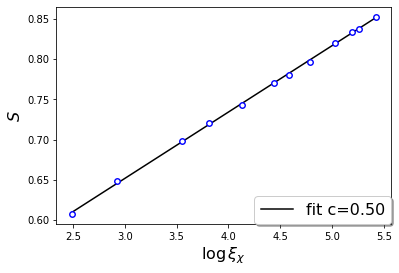

In [5]:
fit_plot_central_charge(s_list, xi_list, "central_charge_ising.pdf")